**FCN - Inspect Weights of a Trained Model

This notebook includes code and visualizations to test, debug, and evaluate the Mask R-CNN model.

## Build FCN Model and display summary

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os, random, pprint
sys.path.append('../')
sys.path.append('../../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import mrcnn.visualize as visualize
import mrcnn.utils as utils
from mrcnn.datagen         import data_generator, load_image_gt, data_gen_simulate
from mrcnn.callbacks       import get_layer_output_1,get_layer_output_2
from mrcnn.utils           import mask_string, parse_image_meta, apply_box_deltas_tf
from mrcnn.prep_notebook   import mrcnn_coco_test, mrcnn_coco_train,  prep_coco_dataset
from mrcnn.coco            import CocoDataset, CocoConfig, CocoInferenceConfig, evaluate_coco, build_coco_results
import mrcnn.model_fcn     as fcn_modellib
from mrcnn.utils           import log
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100,precision=4,threshold=1000, suppress = True)

## Notebook Preferences

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# def get_ax(rows=1, cols=1, size=16):
#     """Return a Matplotlib Axes array to be used in
#     all visualizations in the notebook. Provide a
#     central point to control graph sizes.
    
#     Adjust the size attribute to control how big to render images
#     """
#     _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
#     return ax


## Configurations

DIR_TRAINING = os.path.expanduser('/home/kbardool/models/')
FCN_TRAINING_PATH   = os.path.join(DIR_TRAINING  , "train_fcn_coco")
print(FCN_TRAINING_PATH)
##------------------------------------------------------------------------------------
## Build configuration for FCN model
##------------------------------------------------------------------------------------
fcn_config = CocoConfig()
# fcn_config.IMAGE_MAX_DIM        = 600
# fcn_config.IMAGE_MIN_DIM        = 480      
fcn_config.NAME                 = 'fcn'              
fcn_config.BATCH_SIZE           = 1                 # Batch size is 2 (# GPUs * images/GPU).
fcn_config.IMAGES_PER_GPU       = 1               # Must match BATCH_SIZE
# fcn_config.HEATMAP_SCALE_FACTOR = 4
fcn_config.FCN_INPUT_SHAPE      = fcn_config.FCN_INPUT_SHAPE[0:2] // fcn_config.HEATMAP_SCALE_FACTOR 
# fcn_config.FCN_VGG16_MODEL_PATH = mrcnn_config.FCN_VGG16_MODEL_PATH
fcn_config.TRAINING_PATH        = FCN_TRAINING_PATH
fcn_config.BATCH_MOMENTUM       = 0.9
fcn_config.WEIGHT_DECAY         = 2.0e-4
 
fcn_config.STEPS_PER_EPOCH      = 4
fcn_config.EPOCHS_TO_RUN        = 2
fcn_config.LEARNING_RATE        = 0.01 
fcn_config.LAST_EPOCH_RAN       = 0
fcn_config.VALIDATION_STEPS     = 5
fcn_config.REDUCE_LR_FACTOR     = 0.5
fcn_config.REDUCE_LR_COOLDOWN   = 50
fcn_config.REDUCE_LR_PATIENCE   = 33
fcn_config.EARLY_STOP_PATIENCE  = 50
fcn_config.EARLY_STOP_MIN_DELTA = 1.0e-4
fcn_config.MIN_LR               = 1.0e-10
fcn_config.NEW_LOG_FOLDER       = True  
fcn_config.OPTIMIZER            = 'ADAGRAD'
fcn_config.SYSOUT               = 'screen'
fcn_config.display()

## Build FCN Model

with tf.device(DEVICE):
    ##------------------------------------------------------------------------------------
    ## Build FCN Model in Training Mode
    ##------------------------------------------------------------------------------------
    try :
        del fcn_model
        gc.collect()
    except: 
        pass    
#   fcn_model = fcn_modellib.FCN(mode="training", config=fcn_config, model_dir=fcn_config.TRAINING_PATH)
    fcn_model = fcn_modellib.FCN(mode="inference", arch='FCN8', config=fcn_config)

fcn_model.keras_model.summary()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/kbardool/models/train_fcn_coco

Configuration Parameters:
-------------------------
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_MOMENTUM                 0.9
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
DETECTION_PER_CLASS            200
EARLY_STOP_MIN_DELTA           0.0001
EARLY_STOP_PATIENCE            50
EPOCHS_TO_RUN                  2
FCN_INPUT_SHAPE                [256 256]
GPU_COUNT                      1
HEATMAP_SCALE_FACTOR           4
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LAST_EPOCH_RAN              

## Set weight files

In [26]:
# DIR_WEIGHTS =  'F:/models/train_fcn8_coco/fcn20181031T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
DIR_WEIGHTS =  '/home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000' ### Training with LR=0.00001, MSE Loss NO L2 Regularization
# files = ['fcn_0001.h5','fcn_0027.h5','fcn_0036.h5','fcn_0051.h5','fcn_0076.h5','fcn_0106.h5','fcn_0156.h5']
files   = ['fcn_0001.h5','fcn_0003.h5','fcn_0005.h5','fcn_0010.h5','fcn_0011.h5','fcn_0013.h5','fcn_0039.h5','fcn_0048.h5','fcn_0051.h5','fcn_0073.h5','fcn_0081.h5',]

## Load Weights - 1

In [4]:
weights_path = os.path.join(DIR_WEIGHTS  , files[0])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0001.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0001.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0001.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0001.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 1st weight file

In [5]:
# Show stats of all trainable weights    
a = visualize.display_weight_stats(fcn_model)
weights_stats = os.path.join(DIR_WEIGHTS  , 'stats_'+files[0]+'.pdf')
# utils.convertHtmlToPdf(a, weights_stats) 

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616933
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000014295,+0.0000011685,+0.0000004442
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721671656,+0.0721664876,+0.0415695123
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000019991,+0.0000009980,+0.0000006474
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589253530,+0.0589243956,+0.0339859128
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000027382,+0.0000023353,+0.0000008345
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057409
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000043551,+0.0000023486,+0.0000011290
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416662544,+0.0416666083,+0.0240640398
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000048380,+0.0000030198,+0.0000011331


In [ ]:
from mrcnn.utils import convertHtmlToPdf

### Histograms of Weights - 1st weight file

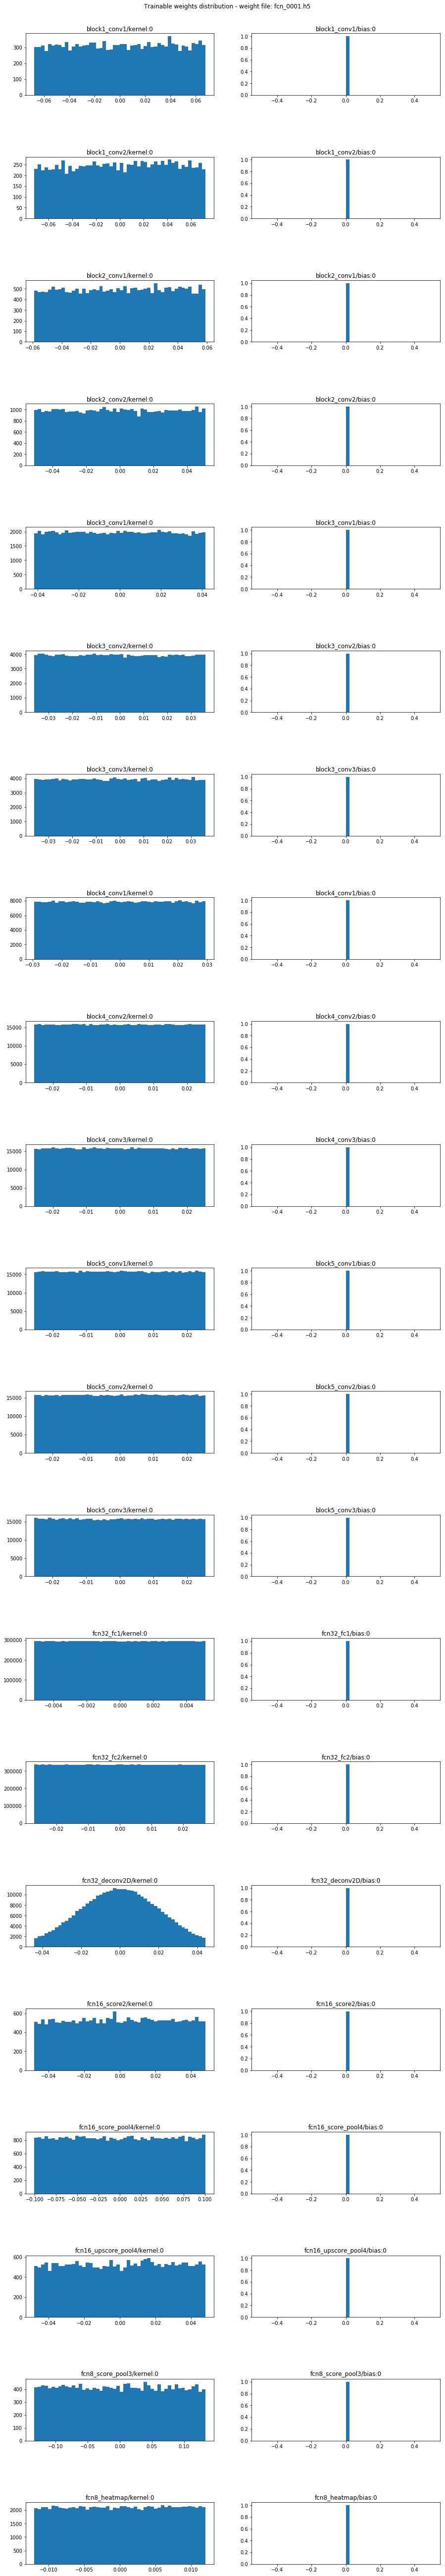

In [6]:
# Pick layer types to display
a = visualize.display_weight_histograms(fcn_model,width=15,height=4, filename = files[0])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[0]+'.png')
a.savefig(weights_histogram)

## Load Weights - 2

In [7]:
weights_path = os.path.join(DIR_WEIGHTS  , files[1])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path)

Loading weights  /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0003.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0003.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0003.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0003.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 2nd weights file

In [8]:
# Show stats of all trainable weights    
visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616896
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000068372,+0.0000056247,+0.0000020597
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721671656,+0.0721664876,+0.0415695123
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000082590,+0.0000041812,+0.0000030101
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589253530,+0.0589243956,+0.0339859128
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000124619,+0.0000097238,+0.0000038814
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057409
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000186122,+0.0000106821,+0.0000050936
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416663550,+0.0416666083,+0.0240640398
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000201460,+0.0000128279,+0.0000050332


'<table><tr><td>LAYER</td><td> WEIGHT NAME</td><td>LAYER TYPE</td><td>SHAPE</td><td>MIN</td><td>MAX</td><td>STD</td></tr><tr><td>  0</td><td>block1_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 81, 64)</td><td>-0.0678042322</td><td>+0.0678054392</td><td>+0.0391616896</td></tr><tr><td>  0</td><td>block1_conv1/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000068372</td><td>+0.0000056247</td><td>+0.0000020597</td></tr><tr><td>  1</td><td>block1_conv2/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 64)</td><td>-0.0721671656</td><td>+0.0721664876</td><td>+0.0415695123</td></tr><tr><td>  1</td><td>block1_conv2/bias:0                     </td><td>Conv2D</td><td>(64,)</td><td>-0.0000082590</td><td>+0.0000041812</td><td>+0.0000030101</td></tr><tr><td>  2</td><td>block2_conv1/kernel:0                   </td><td>Conv2D</td><td>(3, 3, 64, 128)</td><td>-0.0589253530</td><td>+0.0589243956</td><td>+0.0339859128</td></tr><tr><td>  2</td><td>block2

### Histograms of Weights - 2nd weights file

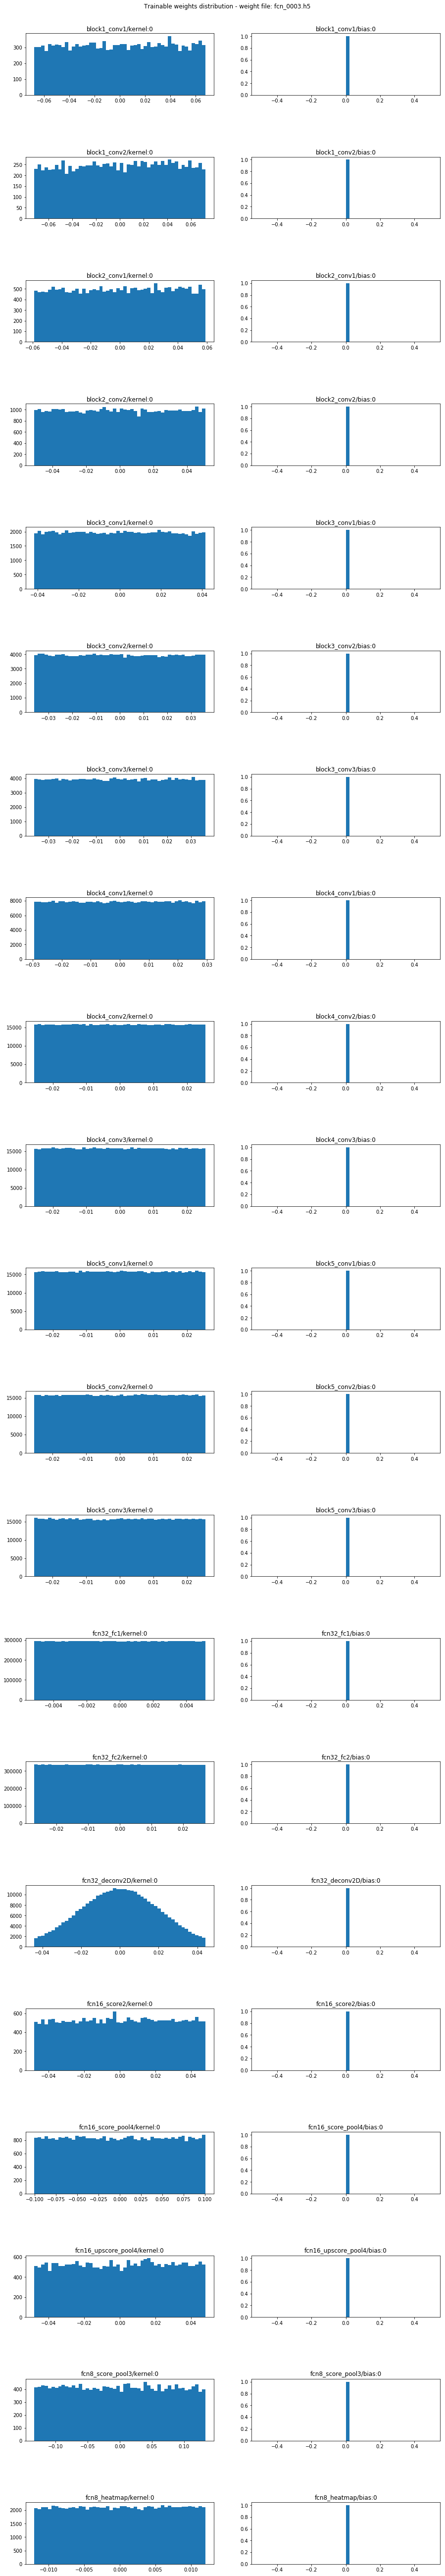

In [9]:
a = visualize.display_weight_histograms(fcn_model, filename = files[1])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[1]+'.png')
a.savefig(weights_histogram)

## Load Weights - 3rd weight file

### load

In [10]:
weights_path = os.path.join(DIR_WEIGHTS  , files[2])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0005.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0005.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0005.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0005.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 3rd weight file

In [12]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616859
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000137751,+0.0000118387,+0.0000042628
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721671656,+0.0721664876,+0.0415695086
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000171783,+0.0000082093,+0.0000061146
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589253530,+0.0589243956,+0.0339859128
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000248673,+0.0000195919,+0.0000077886
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057390
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000360434,+0.0000219409,+0.0000100955
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416664742,+0.0416666083,+0.0240640398
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000383252,+0.0000245028,+0.0000098800


### Histograms of Weights - 3rd weight file

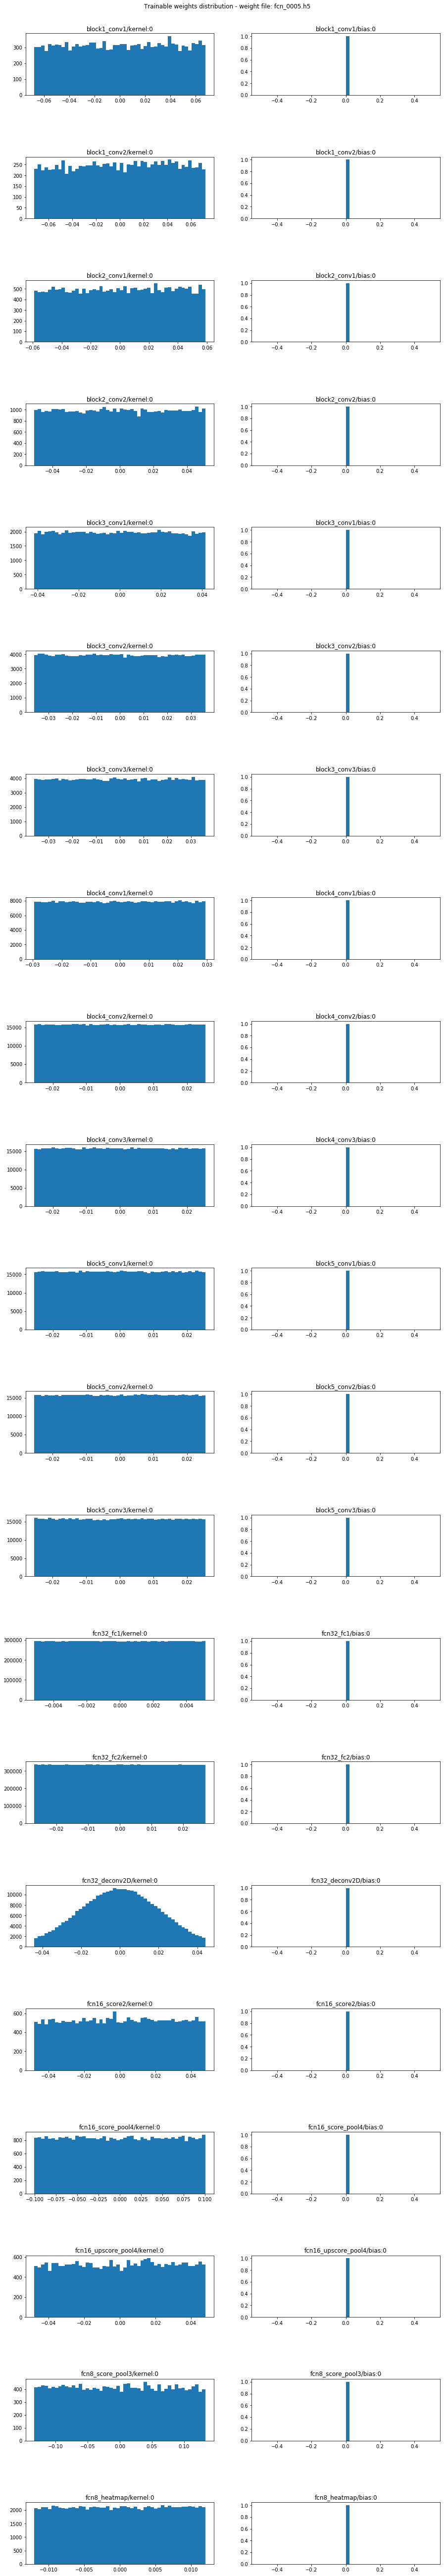

In [13]:
a = visualize.display_weight_histograms(fcn_model, filename = files[2])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[2]+'.png')
a.savefig(weights_histogram)

## Load Weights - 4rd weight file

In [14]:
weights_path = os.path.join(DIR_WEIGHTS  , files[3])
print("Loading weights ", weights_path)
fcn_model.load_model_weights(weights_path) 

Loading weights  /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0010.h5
-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0010.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0010.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0010.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 4th weight file

In [15]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616747
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000340112,+0.0000290240,+0.0000106790
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721672103,+0.0721664429,+0.0415694937
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000433040,+0.0000205491,+0.0000154442
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589255840,+0.0589243099,+0.0339859016
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000599355,+0.0000498866,+0.0000198303
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057334
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000874720,+0.0000528603,+0.0000248703
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416669026,+0.0416666083,+0.0240640361
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000869548,+0.0000604225,+0.0000241741


### Histograms of Weights

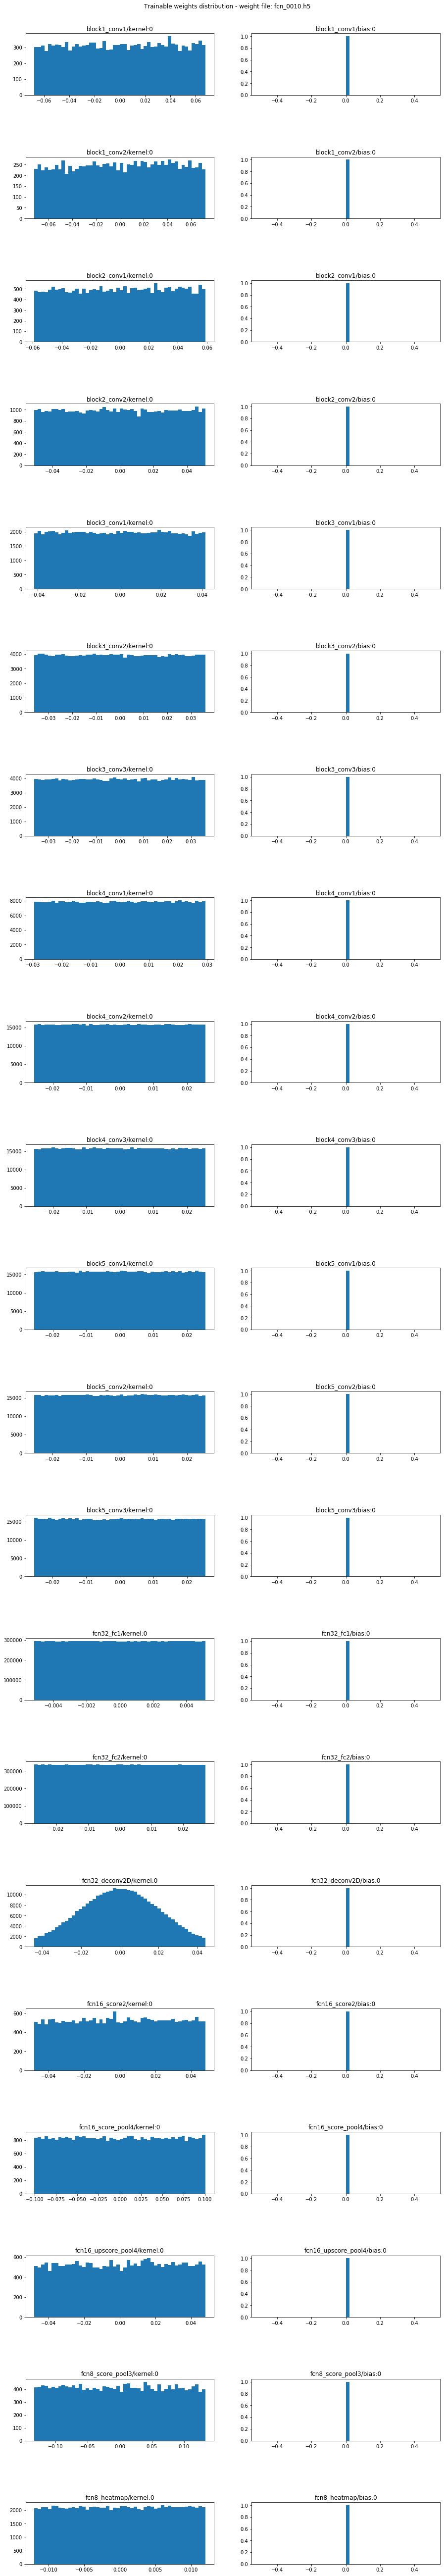

In [16]:
a = visualize.display_weight_histograms(fcn_model, filename = files[3])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[3]+'.png')
a.savefig(weights_histogram)

## Load Weights - 5th weight file

In [17]:
weights_path = os.path.join(DIR_WEIGHTS  , files[4])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0011.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0011.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0011.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 5th weight file

In [18]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616747
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000350251,+0.0000298124,+0.0000109851
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721672103,+0.0721664429,+0.0415694937
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000447088,+0.0000210628,+0.0000158907
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589255840,+0.0589243099,+0.0339859016
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000619594,+0.0000515993,+0.0000204585
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057334
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0000907619,+0.0000539085,+0.0000256843
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416669101,+0.0416666083,+0.0240640361
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0000905937,+0.0000624167,+0.0000250296


### Histograms of Weights - 5th weight file

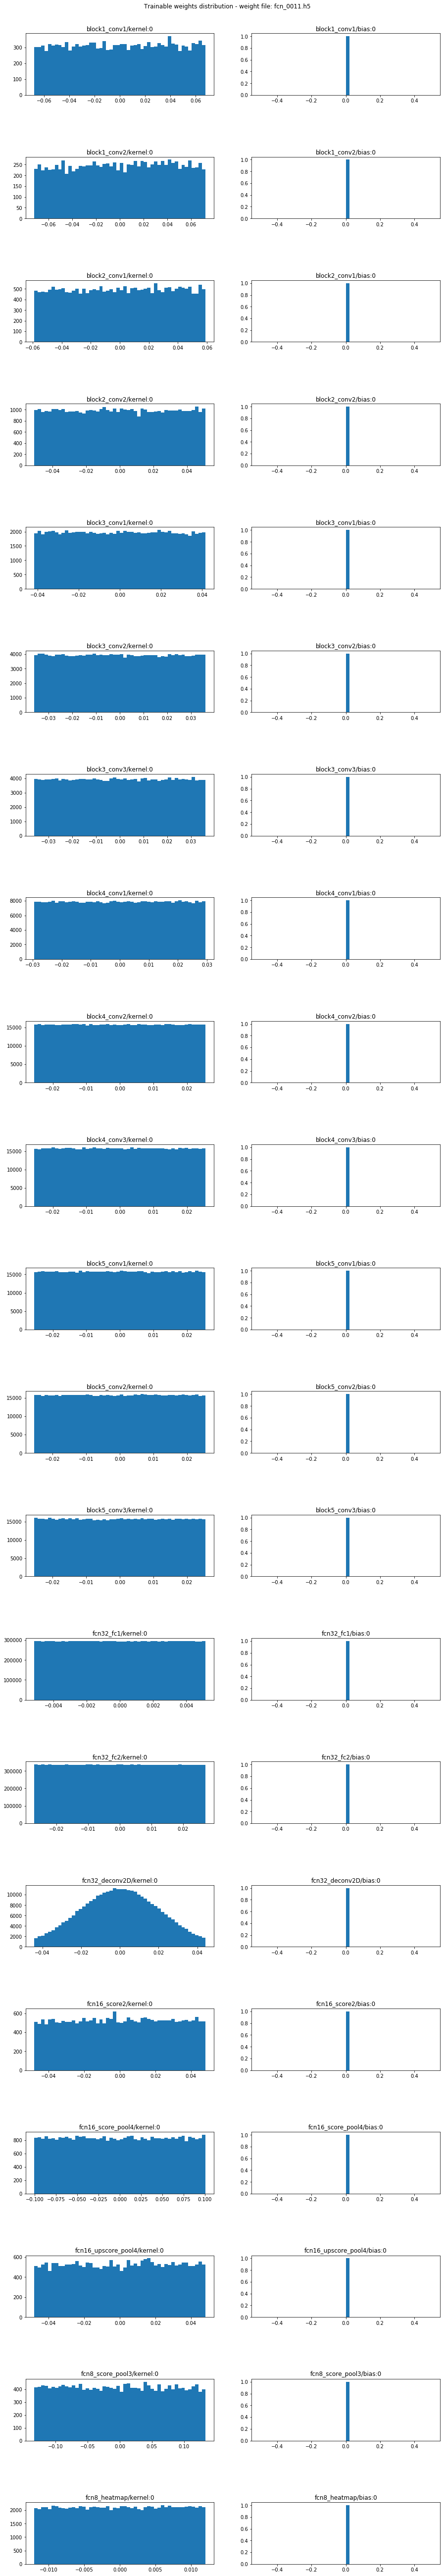

In [19]:
a = visualize.display_weight_histograms(fcn_model, filename = files[4])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[4]+'.png')
a.savefig(weights_histogram)

## Load Weights - 6th weight file

In [20]:
weights_path = os.path.join(DIR_WEIGHTS  , files[5])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0013.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0013.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0013.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 6th weight file

In [21]:
# Show stats of all trainable weights    
_=visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616747
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0000393277,+0.0000334927,+0.0000123955
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721672103,+0.0721664429,+0.0415694937
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0000506212,+0.0000233817,+0.0000178914
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589256026,+0.0589242987,+0.0339859016
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0000706165,+0.0000581133,+0.0000231267
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510309897,+0.0510309637,+0.0295057315
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0001036182,+0.0000600880,+0.0000289694
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416669846,+0.0416666083,+0.0240640361
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0001037543,+0.0000709033,+0.0000282962


### Histograms of Weights - 6th weight file

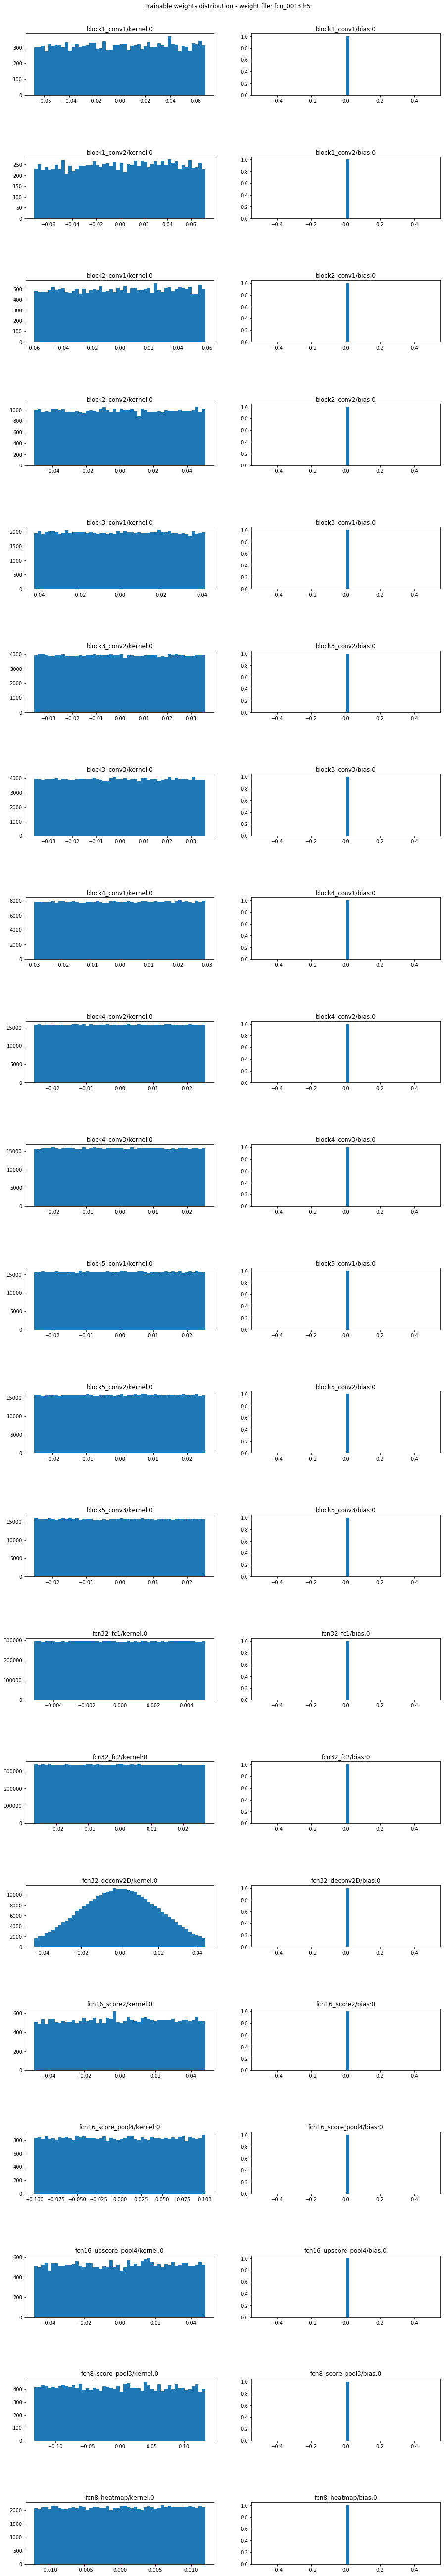

In [22]:
a = visualize.display_weight_histograms(fcn_model, filename = files[5])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[5]+'.png')
a.savefig(weights_histogram)

## Load Weights - 7th weight file

In [23]:
weights_path = os.path.join(DIR_WEIGHTS  , files[6])
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0039.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0039.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0039.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 7th weight file

In [24]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042322,+0.0678054392,+0.0391616151
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0001389087,+0.0001110144,+0.0000434654
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721676201,+0.0721659958,+0.0415694229
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0001882758,+0.0000759728,+0.0000604026
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589272305,+0.0589239858,+0.0339858495
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0002405806,+0.0001909041,+0.0000780315
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510329828,+0.0510309264,+0.0295057055
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0003432247,+0.0001867748,+0.0000962345
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416705757,+0.0416667871,+0.0240640175
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0003359466,+0.0002395364,+0.0000919463


### Histograms of Weights - 7th weight file

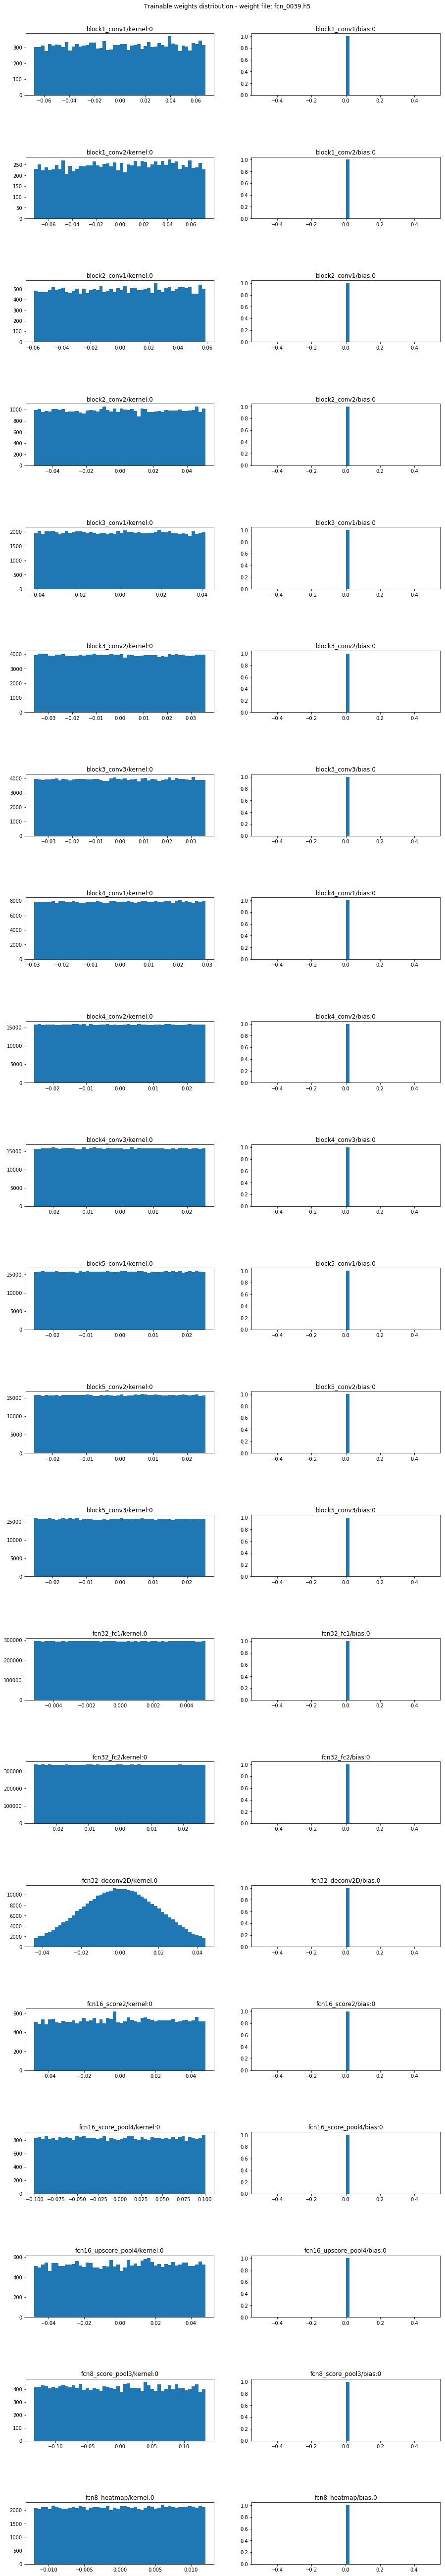

In [25]:
a = visualize.display_weight_histograms(fcn_model, filename = files[6])
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+files[6]+'.png')
a.savefig(weights_histogram)

## Load Weights - 8th weight file

In [28]:
filename = files[7]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0048.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0048.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0048.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 8th weight file

In [29]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042173,+0.0678054392,+0.0391615927
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0001730336,+0.0001340748,+0.0000544482
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721677095,+0.0721659958,+0.0415693969
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0002407534,+0.0000913300,+0.0000748440
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589278750,+0.0589238927,+0.0339858346
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0003029604,+0.0002377170,+0.0000967577
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510345548,+0.0510309078,+0.0295056961
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0004212564,+0.0002319218,+0.0001189796
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416723341,+0.0416670777,+0.0240640100
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0004122321,+0.0003016629,+0.0001128888


### Histograms of Weights - 8th weight file

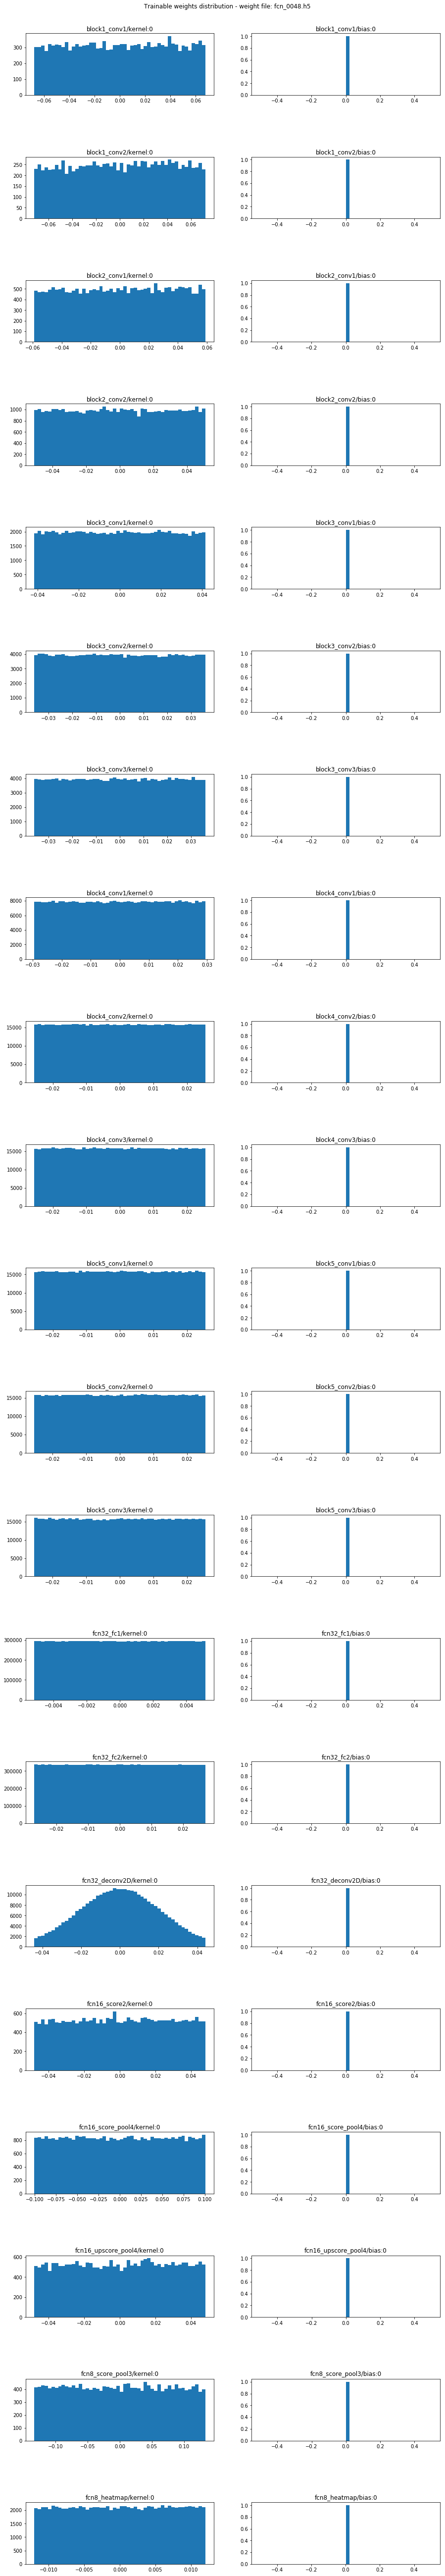

In [30]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 9th weight file

In [31]:
filename = files[8]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0051.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 9th weight file

In [33]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042993,+0.0678054392,+0.0391615890
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0001836142,+0.0001406675,+0.0000577579
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721677393,+0.0721659958,+0.0415693894
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0002564314,+0.0000966926,+0.0000792626
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589281619,+0.0589237697,+0.0339858271
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0003208704,+0.0002524866,+0.0001026464
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510350280,+0.0510308929,+0.0295056943
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0004453983,+0.0002461205,+0.0001259885
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416728295,+0.0416672044,+0.0240640044
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0004364855,+0.0003213162,+0.0001194461


### Histograms of Weights - 9th weight file

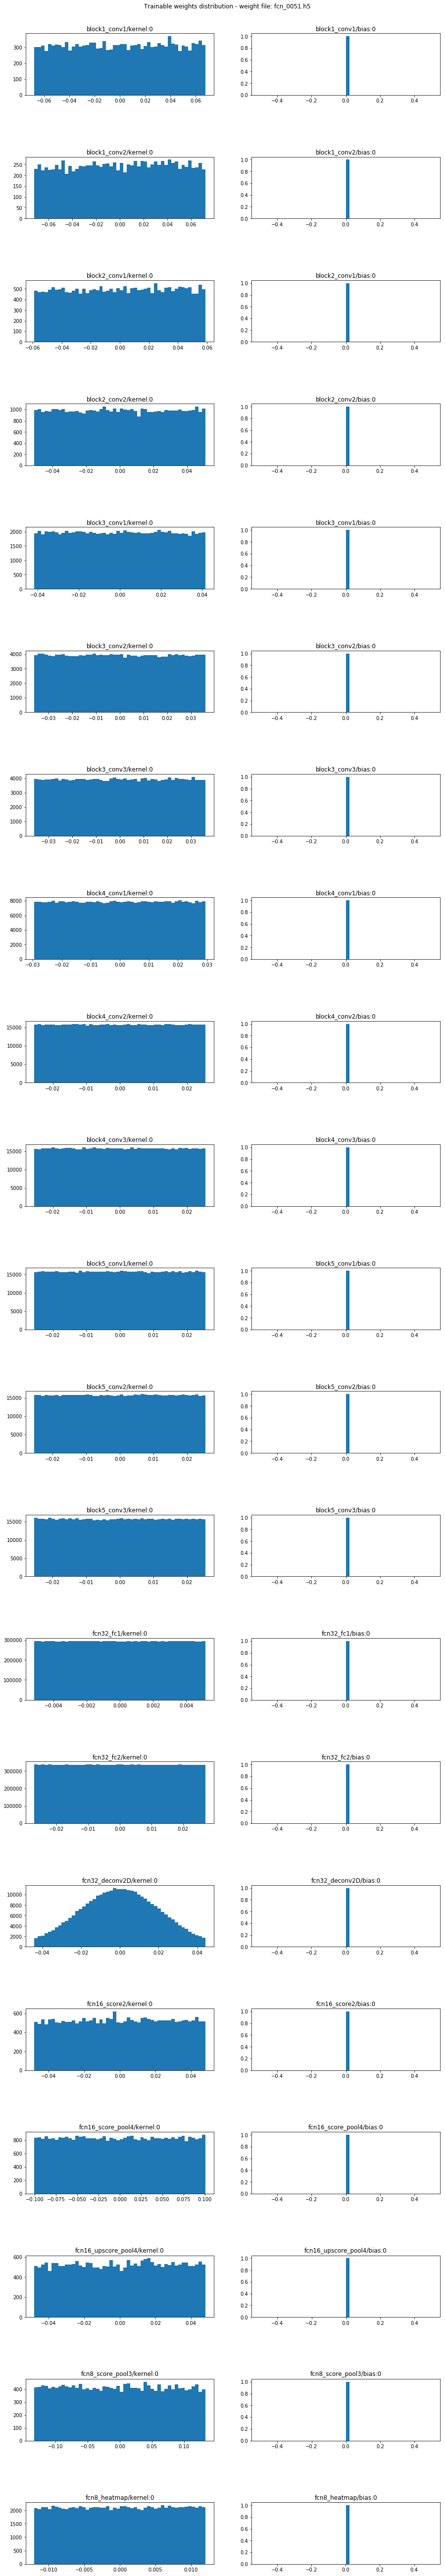

In [34]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 10th weight file

In [35]:
filename = files[9]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0073.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 10th weight file

In [36]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042769,+0.0678054318,+0.0391615406
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0002523395,+0.0001861676,+0.0000822630
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721679926,+0.0721660033,+0.0415693298
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0003719760,+0.0001423818,+0.0001111777
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589296073,+0.0589236207,+0.0339857936
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0004520004,+0.0003455982,+0.0001430740
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510385446,+0.0510308631,+0.0295056719
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0006098283,+0.0003742259,+0.0001750494
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416772589,+0.0416682176,+0.0240639914
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0006054761,+0.0004463716,+0.0001651182


### Histograms of Weights - 10th weight file

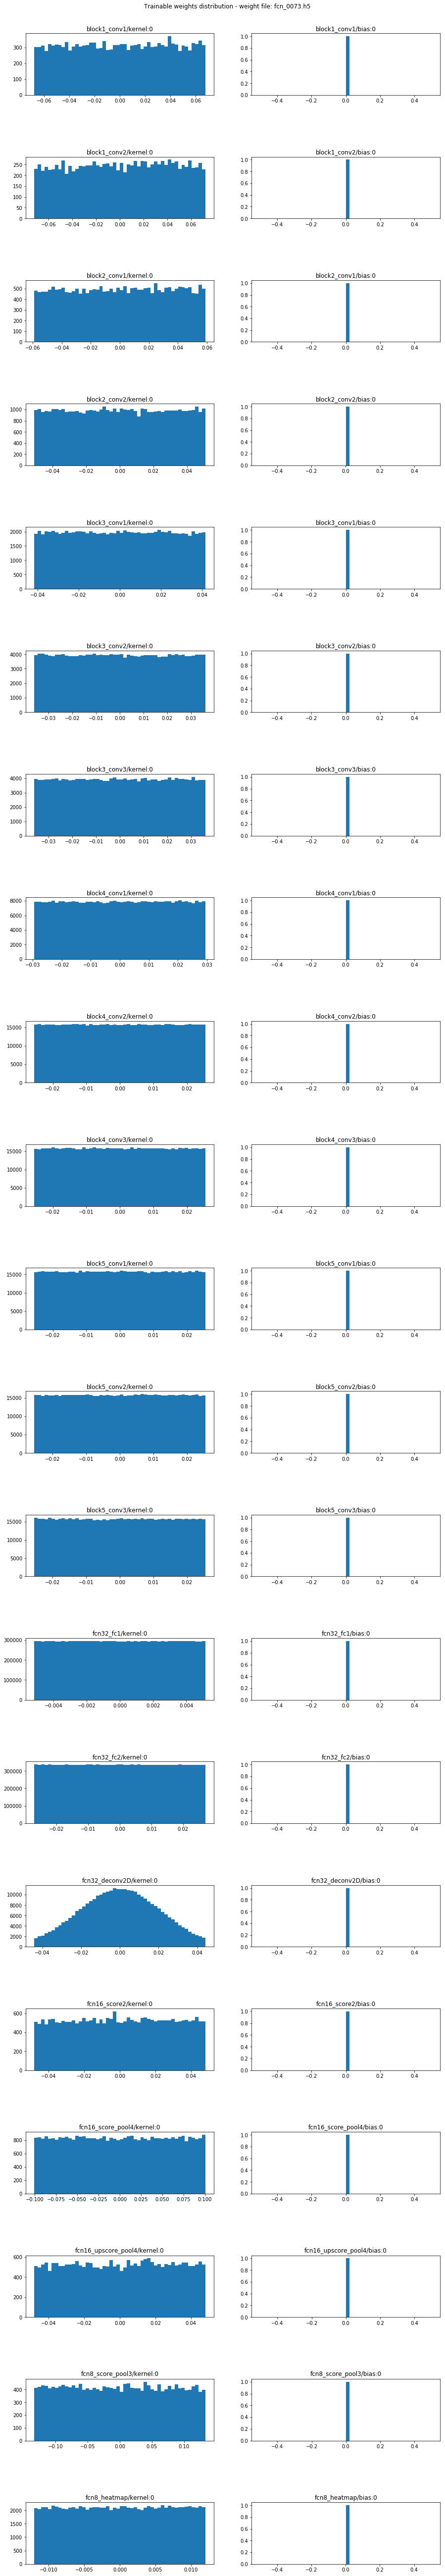

In [37]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)

## Load Weights - 11th weight file

In [38]:
filename = files[10]
weights_path = os.path.join(DIR_WEIGHTS  , filename)
fcn_model.load_model_weights(weights_path) 

-----------------------------------------------
 Load Model with init parm: [ /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5 ]
-----------------------------------------------
 ---> Explicit weight file
>>> load_weights() from : /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5
layers type:  <class 'list'> length:  33
    Weights file loaded: /home/kbardool/models/train_fcn8_coco_adam/fcn20181108T0000/fcn_0081.h5 
FCN  MODEL Load weight file COMPLETE 


### Review Weight Stats - 11th weight file

In [39]:
# Show stats of all trainable weights    
_ = visualize.display_weight_stats(fcn_model)

LAYER,WEIGHT NAME,LAYER TYPE,SHAPE,MIN,MAX,STD
0,block1_conv1/kernel:0,Conv2D,"(3, 3, 81, 64)",-0.0678042769,+0.0678054318,+0.0391615257
0,block1_conv1/bias:0,Conv2D,"(64,)",-0.0002745829,+0.0001991909,+0.0000900953
1,block1_conv2/kernel:0,Conv2D,"(3, 3, 64, 64)",-0.0721680075,+0.0721660033,+0.0415693112
1,block1_conv2/bias:0,Conv2D,"(64,)",-0.0004131656,+0.0001532655,+0.0001221600
2,block2_conv1/kernel:0,Conv2D,"(3, 3, 64, 128)",-0.0589301772,+0.0589236282,+0.0339857750
2,block2_conv1/bias:0,Conv2D,"(128,)",-0.0004959522,+0.0003760874,+0.0001564253
3,block2_conv2/kernel:0,Conv2D,"(3, 3, 128, 128)",-0.0510395393,+0.0510307774,+0.0295056645
3,block2_conv2/bias:0,Conv2D,"(128,)",-0.0006664819,+0.0004180047,+0.0001912711
4,block3_conv1/kernel:0,Conv2D,"(3, 3, 128, 256)",-0.0416786037,+0.0416687764,+0.0240639858
4,block3_conv1/bias:0,Conv2D,"(256,)",-0.0006553022,+0.0004877669,+0.0001796684


### Histograms of Weights - 11th weight file

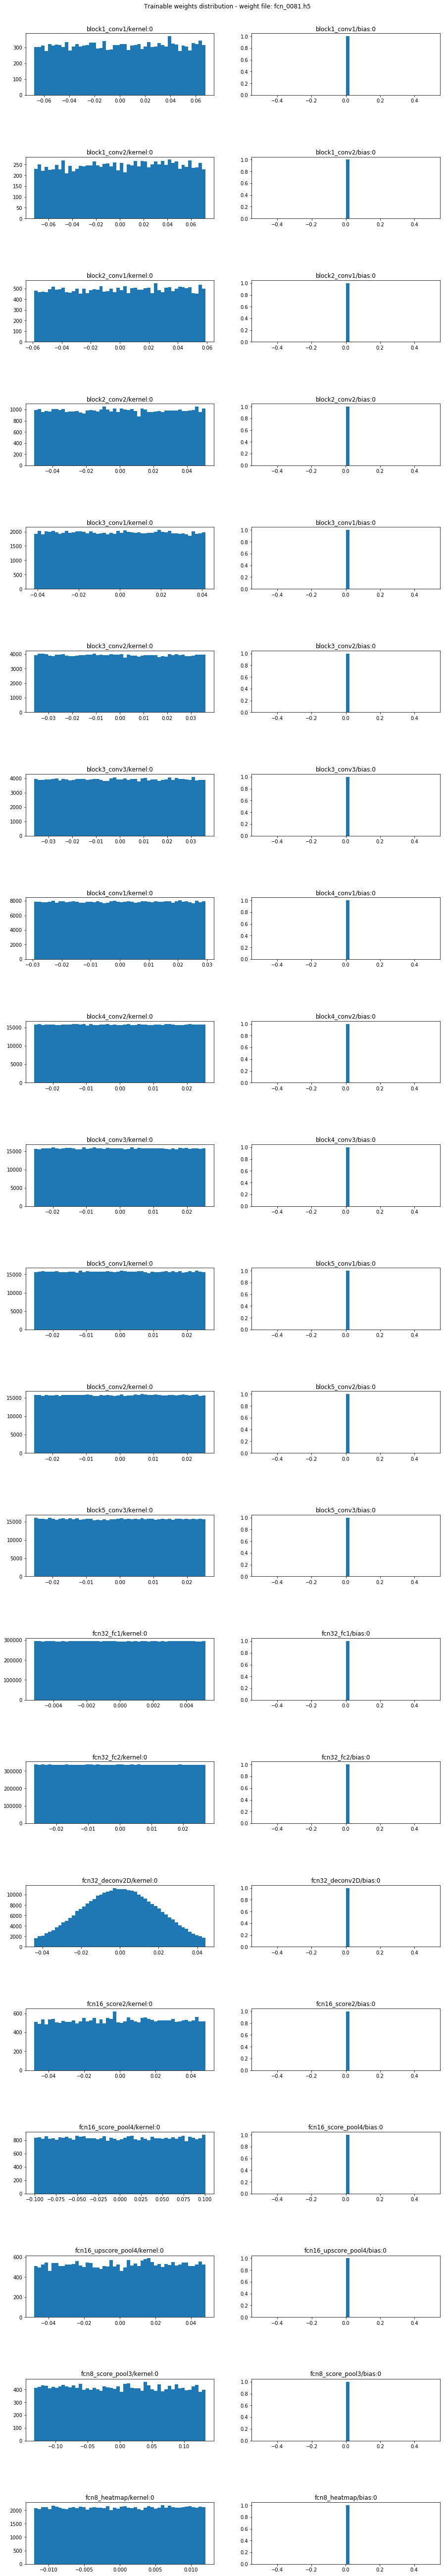

In [40]:
a = visualize.display_weight_histograms(fcn_model, filename = filename)
weights_histogram = os.path.join(DIR_WEIGHTS  , 'histogram_'+filename+'.png')
a.savefig(weights_histogram)